<a href="https://colab.research.google.com/github/ashley-chiteri/air-quality-backend/blob/main/Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio scikit-learn pandas numpy matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Load and inspect your dataset
df = pd.read_csv('cleaned_air_quality_data.csv')  # Replace with your actual filename

print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451411 entries, 0 to 2451410
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   StationId   object 
 1   Datetime    object 
 2   PM2.5       float64
 3   PM10        float64
 4   NO          float64
 5   NO2         float64
 6   NOx         float64
 7   NH3         float64
 8   CO          float64
 9   SO2         float64
 10  O3          float64
 11  Benzene     float64
 12  Toluene     float64
 13  Xylene      float64
 14  AQI         float64
 15  AQI_Bucket  object 
 16  Year        float64
 17  Month       float64
 18  Day         float64
 19  Hour        float64
dtypes: float64(17), object(3)
memory usage: 374.1+ MB
None

First 5 rows:
  StationId             Datetime  PM2.5    PM10    NO    NO2    NOx    NH3  \
0     AP001  2017-11-24 17:00:00  60.50   98.00  2.35  30.80  18.25   8.50   
1     AP001  2017-11-24 18:00:00  65.50  111.25  2.70  24.20  15.07   9.77   
2     AP001  2

In [ ]:
# Data Preprocessing
df['Datetime'] = pd.to_datetime(df['Datetime'])

df['hour'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year

# Convert AQI_Bucket to numerical categories (optional)
aqi_bucket_mapping = {
    'Good': 0,
    'Moderate': 1,
    'Poor for Sensitive Groups': 2,
    'Poor': 3,
    'Very Poor': 4,
    'Hazardous': 5
}
df['AQI_Category'] = df['AQI_Bucket'].map(aqi_bucket_mapping)

# Select relevant features - focusing on Kenya's common pollutants
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'Hour', 'Day', 'Month']
target = 'AQI'  # Using AQI as target variable

# Handle missing values
print("\nMissing values before handling:")
print(df[features + [target]].isnull().sum())

# Simple imputation - you might want to use more sophisticated methods
df[features] = df[features].fillna(df[features].median())
df[target] = df[target].fillna(df[target].median())

print("\nMissing values after handling:")
print(df[features + [target]].isnull().sum())


Missing values before handling:
PM2.5    0
PM10     0
NO2      0
CO       0
SO2      0
O3       0
Hour     1
Day      1
Month    1
AQI      0
dtype: int64

Missing values after handling:
PM2.5    0
PM10     0
NO2      0
CO       0
SO2      0
O3       0
Hour     0
Day      0
Month    0
AQI      0
dtype: int64


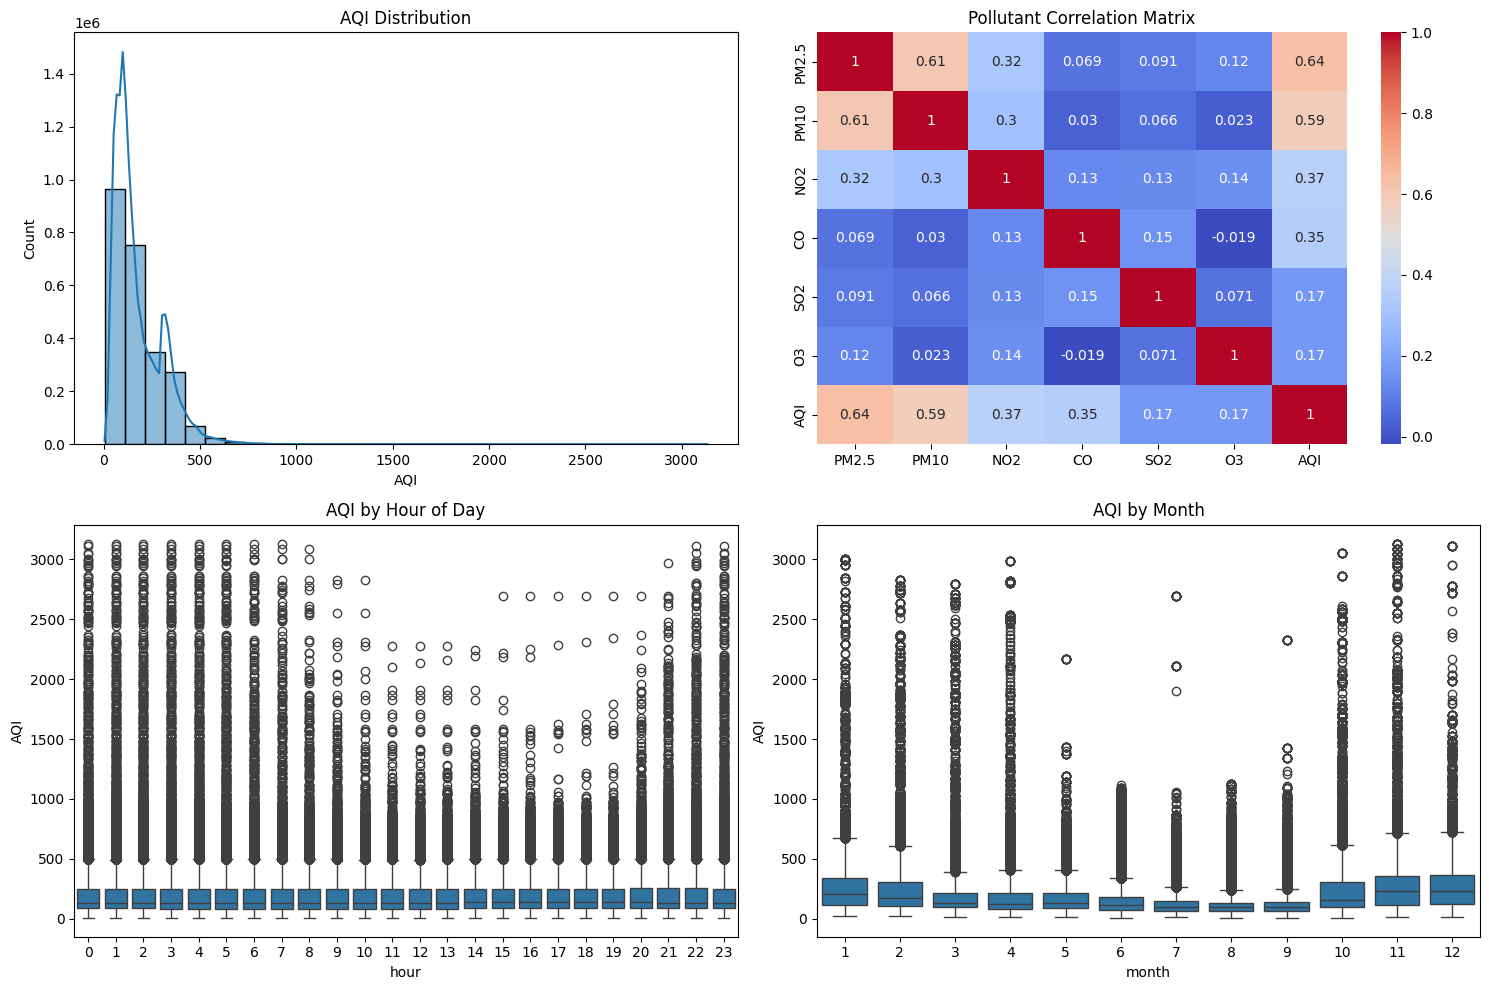

In [ ]:
#  Data Visualization
plt.figure(figsize=(15, 10))

# Plot AQI distribution
plt.subplot(2, 2, 1)
sns.histplot(df['AQI'], bins=30, kde=True)
plt.title('AQI Distribution')

# Plot pollutant correlations
plt.subplot(2, 2, 2)
corr_matrix = df[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Pollutant Correlation Matrix')

# Plot AQI by hour of day
plt.subplot(2, 2, 3)
sns.boxplot(x='hour', y='AQI', data=df)
plt.title('AQI by Hour of Day')

# Plot AQI by month
plt.subplot(2, 2, 4)
sns.boxplot(x='month', y='AQI', data=df)
plt.title('AQI by Month')

plt.tight_layout()
plt.show()

In [ ]:
#  Prepare data for modeling
X = df[features].values
y = df[target].values

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
# Define an improved neural network model
class KenyaAirQualityModelV2(nn.Module):
    def __init__(self, input_size):
        super(KenyaAirQualityModelV2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize improved model
input_size = X_train.shape[1]
model = KenyaAirQualityModelV2(input_size)

# Enhanced training setup
criterion = nn.HuberLoss()  # More robust than MSE for outliers
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


In [ ]:
# Early stopping setup
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

In [ ]:
#Train the model
num_epochs = 200
train_losses = []
val_losses = []
best_model_weights = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        running_loss += loss.item()

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

        # Update learning rate scheduler
        scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_weights = model.state_dict().copy()
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}] | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Val Loss: {val_loss.item():.4f} | '
              f'LR: {current_lr:.2e} | '
              f'Patience: {patience_counter}/{early_stopping_patience}')

    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

# Load best model weights
if best_model_weights:
    model.load_state_dict(best_model_weights)
    print('\nLoaded best model weights based on validation loss')

# Save the trained model
torch.save(model.state_dict(), 'kenya_aqi_model_v2.pth')
print('Model saved successfully')

Epoch [5/200] | Train Loss: 46.4851 | Val Loss: 45.9825 | LR: 5.00e-04 | Patience: 1/10
Epoch [10/200] | Train Loss: 45.5036 | Val Loss: 45.7130 | LR: 5.00e-04 | Patience: 2/10
Epoch [15/200] | Train Loss: 45.0734 | Val Loss: 45.0285 | LR: 5.00e-04 | Patience: 2/10
Epoch [20/200] | Train Loss: 44.6981 | Val Loss: 45.1621 | LR: 2.50e-04 | Patience: 7/10

Early stopping at epoch 23

Loaded best model weights based on validation loss
Model saved successfully


In [ ]:
# evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

    from sklearn.metrics import mean_absolute_error, r2_score
    print("\nFinal Evaluation:")
    print(f"MAE: {mean_absolute_error(y_test_tensor, predictions):.2f}")
    print(f"R2 Score: {r2_score(y_test_tensor, predictions):.2f}")


Final Evaluation:
MAE: 43.06
R2 Score: 0.68


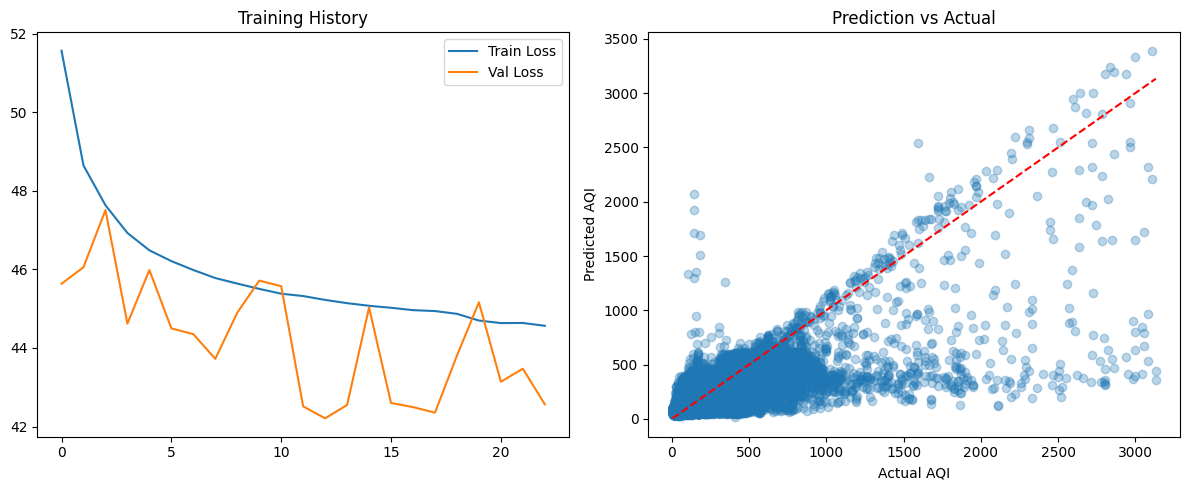

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training History')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_tensor.numpy(), predictions.numpy(), alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Prediction vs Actual')
plt.tight_layout()
plt.show()